# 309.1. Milky Way Dust Extinction Correction

<div style="max-width:300px; float:left; margin-right:1em">
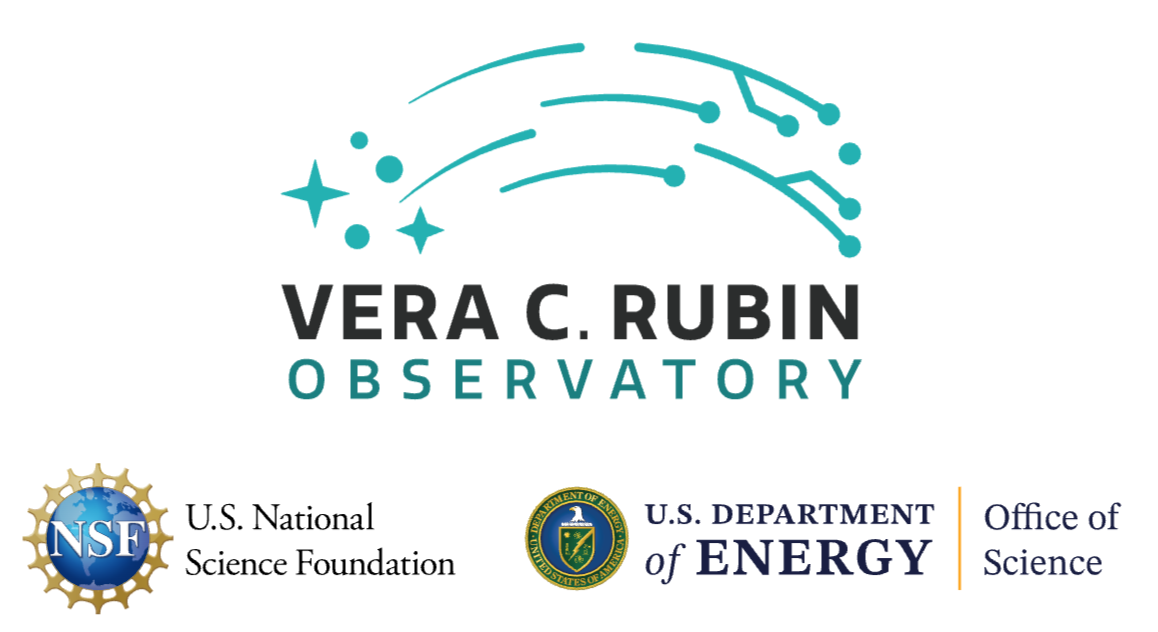
</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="http://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-04 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** To learn how to correct for Milky Way foreground dust extinction.

**LSST data products:** `object`

**Packages:** `lsst.rsp`

**Credit:**
Originally developed by the Rubin Community Science team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

Interstellar dust removes flux by absorbing photons and scattering them out of the observer's line of sight, so called "extinction". The extent of extinction depends on wavelegth. Dust affects shorter (bluer) wavelengths more severely than longer (redder) wavelengths, which leads to a "reddening" of the light. The wavelength dependency is described with an extinction curve, from which the size distribution and composition of interstellar dust grains can be inferred. These extinction curves are used to correct the dust effects on observations. Without dust corrections, the observed properties of celestial objects, such as their intrinsic luminosity and color, will be inaccurate.  

This notebook demonstrates how to correct the effects of dust on observations due to the Galactic foreground dust along the line of sight, using the `ebv` column in the `Object` table from E(B-V) at given ra/dec coordinates per <a href="https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract">Schlegel, Finkbeiner & Davis (1998)</a> (SFD98 hearafter). Interstellar reddening corresponds to the color excess, defined as the difference between an object’s observed and intrinsic (i.e., dust-free) color indices: $E(B-V) = (B-V)_{observed} - (B-V)_{intrinsic}$. E(B-V) measures how much interstellar dust reddens incoming fluxes and serves as a direct proxy for the amount of the line-of-sight extinction. The total-to-selective extinction ratio at wavelength $\lambda$ is defined as $R_\lambda = \frac{A_\lambda}{E(B-V)}$, which characterizes the degree to which dust dims light at that wavelength.

**Related tutorials:** See the 200-level and 300-level DP1 tutorials for guidance on the `Object` table and target exploration.

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), 
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>;
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), and `astropy`, a widely used open-source Python library for astronomy providing core functionality for handling, for example, units, coordinates, time, tables, and FITS files (<a href="https://www.astropy.org/">astropy</a>).

From the LSST pacakge (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>), import modules for accessing the Table Access Protocol (TAP) service, for retrieving datasets from the butler, and geometry handling, and the Butler data access system.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u
from astropy.coordinates import SkyCoord

from lsst.rsp import get_tap_service
from rubin_sim.phot_utils import DustValues

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [3]:
rsp_tap = get_tap_service("tap")
assert rsp_tap is not None

Define a 1-degree radius around the central point of the "low-Galactic-latitude field" RubinSV_95_-25.

In [5]:
ra_cen = 95.0
dec_cen = -25.0
radius = 1.0

List bands available in the field.

In [6]:
bands = "ugrizy"

Set the environment variable `RUBIN_SIM_DATA_DIR` to `/rubin/rubin_sim_data` to make the current `rubin_sim` throughput data available.

In [12]:
os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

## 2. Explore reddening property

The `Object` table contains forced photometric measurements on the deep coadded images at the locations of all objects detected with signal-to-noise ratio > 5 in a `deep_coadd` of any filter, as well as corresponding E(B-V) values from the SFD98 dust map (`ebv` column). Explore the reddening properties in the RubinSV_95_-25 field.

### 2.1. Query `Object` table

Query the `Object` table for coordinates, photometric measurements, extendedness parameter, and E(B-V) values.

In [7]:
query = f"""SELECT objectId, coord_ra, coord_dec,
        u_psfMag, g_psfMag, r_psfMag, i_psfMag, z_psfMag, y_psfMag,
        u_cModelMag, g_cModelMag, r_cModelMag, i_cModelMag, z_cModelMag, y_cModelMag,
        refExtendedness, ebv
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {ra_cen}, {dec_cen}, {radius})) = 1
        ORDER BY objectId ASC
        """

In [8]:
job = rsp_tap.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


Fetch the results and store them as a table.

In [9]:
table = job.fetch_result().to_table()
print(f'The query returned {len(table)} objects.')

The query returned 348913 objects.


Option to display the table of results.

In [ ]:
# table

### 2.2. Display maps

Display the object count map as well as the median E(B-V) map for the field.

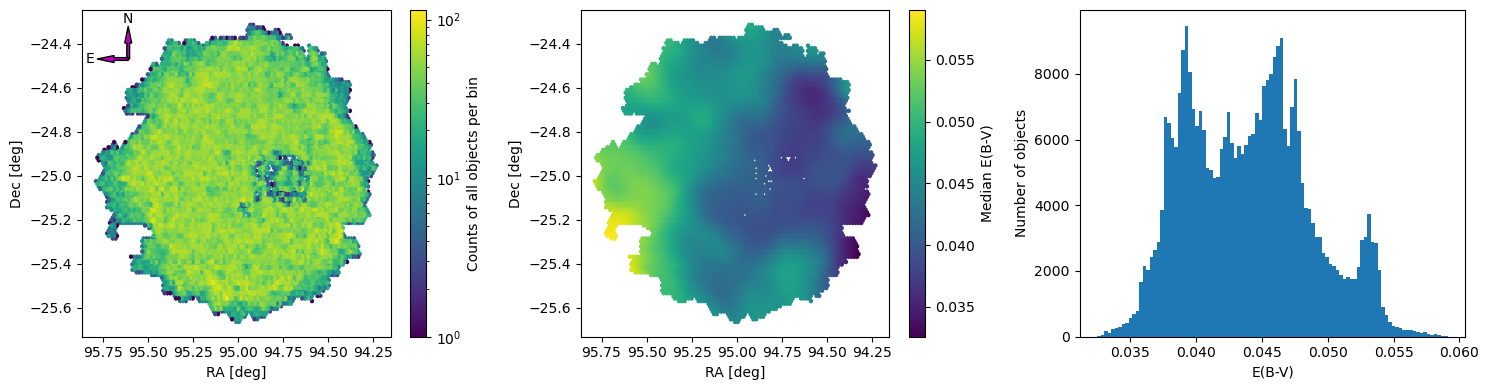

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

hb = ax1.hexbin(table['coord_ra'], table['coord_dec'], gridsize=100, bins='log')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('Dec [deg]')
ax1.invert_xaxis()
cb = fig.colorbar(hb, ax=ax1, label='Counts of all objects per bin')
ax1.annotate('', xy=(0.15, 0.95), xytext=(0.15, 0.85),
            arrowprops=dict(facecolor='m', width=2, headwidth=5),
            xycoords='axes fraction')
ax1.text(0.15, 0.95, 'N', transform=ax1.transAxes,
        ha='center', va='bottom', fontsize=10)
ax1.annotate('', xy=(0.05, 0.85), xytext=(0.15, 0.85),
            arrowprops=dict(facecolor='m', width=2, headwidth=5),
            xycoords='axes fraction')
ax1.text(0.04, 0.85, 'E', transform=ax1.transAxes,
         ha='right', va='center', fontsize=10)

hb2 = ax2.hexbin(table['coord_ra'], table['coord_dec'], table['ebv'], 
                 reduce_C_function=np.ma.median, gridsize=100)
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('Dec [deg]')
ax2.invert_xaxis()
cb = fig.colorbar(hb2, label="Median E(B-V)")

ax3.hist(table['ebv'], bins=100)
ax3.set_xlabel('E(B-V)')
ax3.set_ylabel('Number of objects')

plt.tight_layout()
plt.show()

> **Figure 1:** The left panel shows the spatial distribution of all objects in the field, which is nearly uniform. The middle panel presents the median reddening per spatial bin, revealing a clear gradient with higher reddening toward the east. The uniform star count map indicates that this reddening graident is unrelated to stellar density. The right panel shows the distribution of `E(B-V)` values in the field.

## 3. Correct the effects of dust

In `rubin_sim.phot_utils`, `DustValues().r_x` provides the $R_{\lambda}$ values for the Rubin filters. These values are calculated using the CCM89 extinction curve ([Cardelli, Clayton, and Mathis 1989](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract)), assuming a *flat* spectral energy distribution. The default $R_{V}$ is 3.1 (for the Milky Way diffuse ISM), but it is possible to specify a different value with the keyword argument `r_v`.

Print out $R_{\lambda}$ values for $ugrizy$.

In [13]:
R_band = DustValues().r_x
print(R_band)

{'u': np.float64(4.757217815396922), 'g': np.float64(3.6605664439892625), 'r': np.float64(2.70136780871597), 'i': np.float64(2.0536599130965882), 'z': np.float64(1.5900964472616756), 'y': np.float64(1.3077049588254708)}


### 3.1. Compute extinction

$E(B−V)$ sets the scale of dust along the line of sight, while $R_\lambda$, combined with an extinction curve, specifies the wavelength dependance. Together, extinction in a given band can be computed as: $A_\lambda = R_\lambda\times\,E(B-V)$. Apply this relation to compute extinction in each band.

In [14]:
A_band = {band: R_band[band] * table['ebv'] for band in bands}

### 3.2. Apply extinction corrections

Apply extinction corrections to the observed magnitudes in each band ($m_{\lambda,0} = m_\lambda - A_\lambda$), and add the corrected magnitudes back into the table.

In [15]:
for band in bands:
    table[f"{band}_psfMag0"] = table[f"{band}_psfMag"] - A_band[band]
    table[f"{band}_cModelMag0"] = table[f"{band}_cModelMag"] - A_band[band]

### 3.3. Compare magnitudes

Compare magnitudes before and after dust correction both for stars (i.e., `refExtendedness` = 0) and galaxies (i.e., `refExtendedness` = 1). 

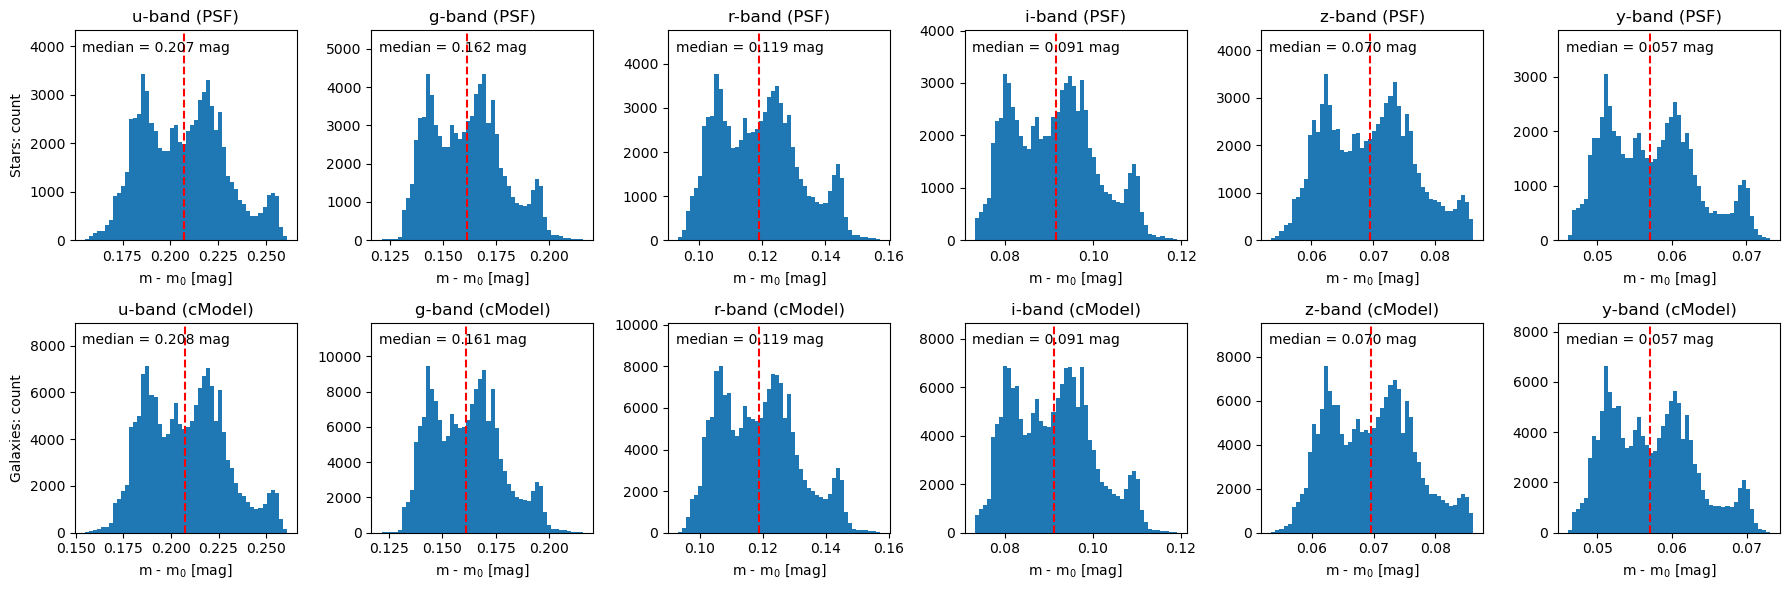

In [16]:
is_star = table['refExtendedness'] == 0
is_galaxy = table['refExtendedness'] == 1

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey=False)
plt.subplots_adjust(wspace=0.25, hspace=0.35)

for j, b in enumerate(bands):
    m  = table[f"{b}_psfMag"]
    m0 = table[f"{b}_psfMag0"]
    ok = is_star & np.isfinite(m) & np.isfinite(m0)
    dmag = np.asarray(m[ok]) - np.asarray(m0[ok])

    ax = axes[0, j]
    ax.hist(dmag, bins=50)
    med = np.median(dmag) if dmag.size else np.nan
    if np.isfinite(med):
        ax.axvline(med, c="r", linestyle="--")
        y_max = ax.get_ylim()[1]
        ax.text(0.7, 0.95, f"median = {med:.3f} mag", transform=ax.transAxes,
                ha="right", va="top")
    ax.set_title(f"{b}-band (PSF)")
    if j == 0:
        ax.set_ylabel("Stars: count")
    ax.set_xlabel(r"m - m$_{0}$ [mag]")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.2)

    m  = table[f"{b}_cModelMag"]
    m0 = table[f"{b}_cModelMag0"]
    ok = is_galaxy & np.isfinite(m) & np.isfinite(m0)
    dmag = np.asarray(m[ok]) - np.asarray(m0[ok])
    
    ax = axes[1, j]
    ax.hist(dmag, bins=50)
    med = np.median(dmag) if dmag.size else np.nan
    if np.isfinite(med):
        ax.axvline(med, c="r", linestyle="--")
        ax.text(0.7, 0.95, f"median = {med:.3f} mag", transform=ax.transAxes,
                ha="right", va="top")
    ax.set_title(f"{b}-band (cModel)")
    if j == 0:
        ax.set_ylabel("Galaxies: count")
    ax.set_xlabel(r"m - m$_{0}$ [mag]")
    ax.set_xlabel(r"m - m$_{0}$ [mag]")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.2)

plt.tight_layout()
plt.show()

> **Figure 2:** Histograms of magnitude differences between observed and dust-corrected values for stars (top row, PSF magnitudes) and galaxies (bottom row, cModel magnitudes) in the $ugrizy$ bands. The median of each distribution is marked with a red dashed line, and its value is printed inside the panel. The differences are largest in the bluest $u$ band and decrease toward longer wavelengths, with the reddest $y$ band showing the smallest dust effect, independent of the photometric measurement (PSF vs. cModel).

## 4. Caveat for using the SFD98 map

The SFD98 map is uncertain and unreliable at |b| < 5$^{\circ}$ sightlines due to contaminating sources in the 100 $\mu$m dust emission map. The Seagull nebula sits in that zone. The Seagull nebula is also a home for new born stars. It is an HII complex with hot, structured dust. The SFD98 map is known to be biased in these conditions. It also gives the full column to infinity; much of the dust toward the Seagull is at 1-2 kpc. In short, using the SFD98 map on foreground stars or nearby HII regions over-corrects them.

### 4.1. Retrieve Seagull Nebula data

Query the `Object` table for the Seagull Nebula field and examine the failure mode of using the `ebv` column. Frist, define the field's central position in ICRS equatorial cooridnates, then convert it to the Galactic coordinates to show that it lies very close to the Milky Way plane. 

In [18]:
ra_cen_seagull = 106.23
dec_cen_seagull = -10.51

c = SkyCoord(ra=ra_cen_seagull*u.degree, dec=dec_cen_seagull*u.degree, frame='icrs')
print(c.galactic)

<SkyCoord (Galactic): (l, b) in deg
    (223.81433784, -1.81816688)>


In [26]:
query = f"""SELECT objectId, coord_ra, coord_dec,
        g_psfMag, r_psfMag, ebv
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {ra_cen_seagull}, {dec_cen_seagull}, {radius})) = 1
        AND refExtendedness = 0
        ORDER BY objectId ASC
        """

In [27]:
job = rsp_tap.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


In [28]:
table_seagull = job.fetch_result().to_table()
print(f'The query returned {len(table_seagull)} objects.')

The query returned 44259 objects.


### 4.2. Apply extinction correction

Repeat the procedures from Sections 3.1 and 3.2 to apply dust corrections to the Seagull Nebula field photometry, limiting the correction to the retrieved $g$ and $r$ bands.

In [29]:
bands_seagull = "gr"
A_band = {band: R_band[band] * table_seagull['ebv'] for band in bands_seagull}

for band in bands_seagull:
    table_seagull[f"{band}_psfMag0"] = table_seagull[f"{band}_psfMag"] - A_band[band]

Compare the ($g-r$, $g$) color-magnitude diagram constructed from the observed photometry with that built from the dust-corrected photometry. 

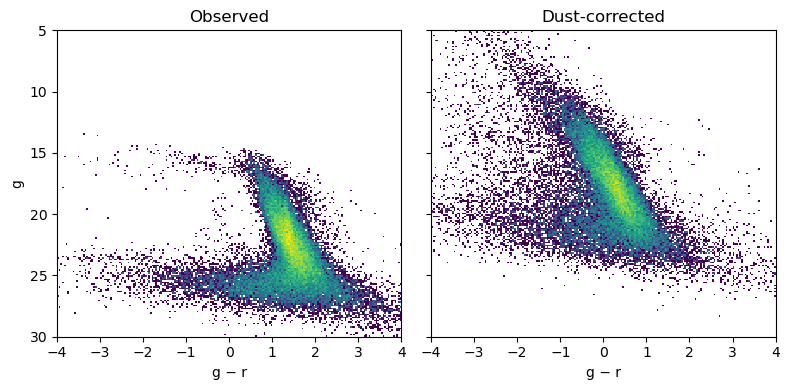

In [32]:
ok = np.isfinite(table_seagull["g_psfMag"])  & np.isfinite(table_seagull["r_psfMag"])

g = table_seagull["g_psfMag"][ok]
r = table_seagull["r_psfMag"][ok]
g0 = table_seagull["g_psfMag0"][ok]
r0 = table_seagull["r_psfMag0"][ok]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

h1 = axes[0].hist2d(
    g-r, g,
    range=[(-4, 4), (5, 30)],
    bins=200,
    norm=LogNorm()
)
axes[0].set_xlabel("g − r")
axes[0].set_ylabel("g")
axes[0].set_title("Observed")
axes[0].invert_yaxis()

h2 = axes[1].hist2d(
    g0-r0, g0,
    range=[(-4, 4), (5, 30)],
    bins=200,
    norm=LogNorm(vmax=h1[0].max())
)
axes[1].set_xlabel("g − r")
axes[1].set_title("Dust-corrected")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

> **Figure 3:** $(g-r,\, g)$ color–magnitude diagrams of the Seagull Nebula field using observed magnitudes (left) and dust-corrected magnitudes (right). The increased scatter in the stellar sequence demonstrates that the SFD98-based dust correction does not perform reliably for this field. While the average $E(B-V)$ value from the 2D SFD98 map agrees with the reddening reported by the 3D dust map at the distance of the Seagull Nebula ([Bayestar dust map](http://argonaut.skymaps.info/)), many individual values are significantly larger than expected from the 3D map.

## 5. Exercise for the learner

Apply dust correction with a different $R_{V}$ than the default 3.1 using the keyword argument `r_v` in `DustValues()`. Compare these photometry with those corrected with $R_{V}$ = 3.1 in Section 3.